<span style = "color:blue; font-size:24px">ARIMADecisionTreeTester</span>
<span style = "color:blue; font-size:24px">MultiYear</span>
<span style = "color:blue; font-size:24px"> Reconnaissance<span>

ZeekData24 Attack Profiles

Dataset 1: Multiple Attack Types (Credential Access|236706|, Reconnaissance|12762|, Initial Access|2172|, Privilege Escalation|1251|, Persistence|1251|, Defense Evasion|1251|, Exfiltration|50|)

Dataset 2: Multiple Attack Types (Credential Access|45491|, Reconnaissance|3339|, Initial Access|576|, Privilege Escalation|336|, Persistence|336|, Defense Evasion|336|, Exfiltration|30|)

Dataset 3: Multiple Attack Types (Credential Access|150887|, Reconnaissance|10834|, Initial Access|2090|, Privilege Escalation|1193|, Persistence|1193|, Defense Evasion|1193|, Exfiltration|188|)

Dataset 4: Multiple Attack Types (Credential Access|341945|, Reconnaissance|24233|, Initial Access|4602|, Privilege Escalation|2591|, Persistence|2591|, Defense Evasion|2591|, Exfiltration|268|)

Dataset 5: Multiple Attack Types (Credential Access|96159|, Reconnaissance|6927|, Initial Access|1222|, Privilege Escalation|677|, Persistence|677|, Defense Evasion|677|, Exfiltration|23|)

Datest 6: Benign Data

Dataset 7: Benign Data

Zeekdata22 Attack Profiles

Dataset 1: Benign

Dataset 2: Attacks (Reconnaissance|9278720|, Discovery|2086|)

Dataset 3: Attacks (Credential Access|31|, Privilege Escalation|13|, Exfiltration|7|, Lateral Movement|4|, Resource Development|3|, Reconnaissance|2|, Persistence|1|, Initial Access|1|, Defense Evasion|1|)

This revision tests the Decision Tree Model on different combinations of 2022 and 2024 data but focuses on Credential Access.

NOTE: This revision is adapted to implement an upgrade python 3.12 version which does not allow for the use of pdmarima, so the arima_functions script must use statsmodels to work properly. Previous versions may be considered obsolete when using this new version of python.

<span style = "color:blue; font-size:24px">Preprocessing for ARIMA Model</span>

In [ ]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

UID = "raf46"                   # Your Argonet ID.
hadoop_master = "192.168.1.250"  # IP address to Spark Master, which, for our cluster, is the same as the Hadoop Name node address.  
# Create spark session with variables below.  Please try to remember to add your argonet ID to the appName, so that we know who a running job belongs to.
spark = SparkSession.builder.appName("Pyspark Example Script - " + UID)                        \
                            .master("spark://" + hadoop_master + ":7077")                      \
                            .config("SPARK_LOCAL_IP", hadoop_master)                           \
                            .config("spark.driver.cores", "2")                                 \
                            .config("spark.driver.memory", "128g")                              \
                            .config("spark.executor.memory", "128g")                            \
                            .config("spark.executor.cores", "4")                               \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true")                 \
                            .config("spark.dynamicAllocation.minExecutors", "2")               \
                            .config("spark.dynamicAllocation.maxExecutors", "8")               \
                            .config("spark.executor.instances", "4")                           \
                            .getOrCreate()

def load_data(data_paths):
    df_list = []
    for i, path in enumerate(data_paths):
        print(f"Loading data from path {i+1}/{len(data_paths)}: {path}")
        df = spark.read.parquet(path)
        df_list.append(df)
        print(f"Count of rows in dataset:  {df.count()}")
    print("Data loading complete.")
    return df_list

def process_data_ARIMA(df_list):
    processed_df_list = []
    mitre_labels = [
        "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
        "Credential Access", "Discovery", "Lateral Movement", "Collection",
        "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
    ]

    for i, df in enumerate(df_list):
        print(f"Processing DataFrame {i+1}/{len(df_list)}")
        df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))
        df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
        df = df.withColumn("label_tactic_binary_encoded", F.expr(
            "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
        ))
        df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
        window_size = "1 seconds"
        df_agg = df.groupBy(F.window("ts", window_size)) \
            .agg(
                F.sum("duration").alias("sum_duration"),
                F.sum("orig_bytes").alias("sum_orig_bytes"),
                F.sum("resp_bytes").alias("sum_resp_bytes"),
                F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
                F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
                F.count("*").alias("connection_count"),
                F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
                F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
                F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
            )
        df_agg_flat = df_agg.select(
            F.col("window.start").alias("window_start"),
            F.col("window.end").alias("window_end"),
            "sum_duration",
            "sum_orig_bytes",
            "sum_resp_bytes",
            "sum_orig_ip_bytes",
            "sum_resp_ip_bytes",
            "connection_count",
            "label_tactic_binary_agg",
            "label_tactic_split_agg",
            "label_tactic_binary_encoded_agg"
        )
        df_agg_sorted = df_agg_flat.orderBy("window_start")
        df_pandas_sorted = df_agg_sorted.toPandas()
        df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])
        processed_df_list.append(df_pandas_sorted)
        print(f"DataFrame {i+1} processed successfully.")
    print("Data processing complete.")
    return processed_df_list

# Define paths
data_paths = [
   "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
    ]

# Define target Attack type
valid_tactics = ["Reconnaissance", "none"]

# Load and combine data, then shuffle
def combine_and_shuffle_data(data_paths, random_seed=42):
    # Load and combine all data
    df_list = load_data(data_paths)

    # Select relevant columns and fill na before combining
    for i in range(len(df_list)):
        df_list[i] = df_list[i].select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
        df_list[i] = df_list[i].fillna({
            "duration": 0,
            "orig_bytes": 0,
            "resp_bytes": 0,
            "orig_ip_bytes": 0,
            "resp_ip_bytes": 0,
            "label_tactic": "none"
        })
    # Combine all processed DataFrames
    combined_df = df_list[0]
    print(f"Initial DataFrame row count: {combined_df.count()}")
    for df in df_list[1:]:
        combined_df = combined_df.union(df)
        i=0

    # Shuffle the combined DataFrame
    shuffled_df = combined_df.orderBy(F.rand(seed=random_seed))
    print(f"Row count after shuffling: {shuffled_df.count()}")
    
    print("Data combined and shuffled successfully.")
    return shuffled_df

# Combine and shuffle the data
shuffled_df = combine_and_shuffle_data(data_paths)

# Create a pseudo timestamp column with one-minute increments
shuffled_df = shuffled_df.withColumn(
    "ts",
    F.unix_timestamp(F.current_timestamp()) + (F.row_number().over(Window.orderBy(F.rand())) * 60)
)

# Show the first few rows of the updated DataFrame
shuffled_df.show(truncate=False)

# Show the total count of rows
print(f"Total number of rows in the shuffled DataFrame: {shuffled_df.count()}")

# Add an index column to the DataFrame
shuffled_df_with_index = shuffled_df.withColumn("row_index", F.monotonically_increasing_id())

# Split the DataFrame into chunks of 10,000 rows
chunk_size = 10000
dataframe_chunks = []

for i in range(0, shuffled_df_with_index.count(), chunk_size):
    chunk = shuffled_df_with_index.filter(
        (F.col("row_index") >= i) & (F.col("row_index") < i + chunk_size)
    ).drop("row_index")  # Drop the index column after filtering
    dataframe_chunks.append(chunk)

# Print confirmation
print(f"Shuffled DataFrame split into {len(dataframe_chunks)} chunks of {chunk_size} rows each.")

shuffled_df = dataframe_chunks[0]  # Use the first chunk with 10,000 rows for further processing

# Split the shuffled DataFrame into a Train and Test set using a 70/30 split
train_test_split = shuffled_df.randomSplit([0.7, 0.3], seed=42)
train_df = train_test_split[0]
test_df = train_test_split[1]

# Add the train and test DataFrames to a list
train_test_list = [train_df, test_df]

# Print confirmation
print("Train and Test DataFrames added to train_test_list successfully.")

# Optional: Show the sizes of the train and test DataFrames
print(f"Training DataFrame size: {train_df.count()} rows")
print(f"Testing DataFrame size: {test_df.count()} rows")

# Preprocess data for ARIMA model
processed_df_list = process_data_ARIMA(train_test_list)

# Define training and testing datasets for ARIMA model
df_train_sample = processed_df_list[0]
df_test_sample = processed_df_list[1]
# Create original DataFrames for test set
df_test_original = df_test_sample.copy()

25/04/05 09:17:20 WARN Utils: Your hostname, car-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.123 instead (on interface ens33)
25/04/05 09:17:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/05 09:17:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/05 09:17:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/04/05 09:17:22 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Loading data from path 1/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet


Count of rows in dataset:  255443
Loading data from path 2/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet
Count of rows in dataset:  50444
Loading data from path 3/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet
Count of rows in dataset:  167578
Loading data from path 4/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet
Count of rows in dataset:  378821
Loading data from path 5/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet
Count of rows in dataset:  106362
Loading data from path 6/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDat

25/04/05 09:17:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:17:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:17:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:17:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:17:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:17:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

+----------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts        |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+----------+---------------------+----------+----------+-------------+-------------+-----------------+
|1743862722|2.100827932357788    |1044      |16681     |6496         |70292        |Credential Access|
|1743862782|3.8504600524902344E-4|0         |0         |240          |0            |Reconnaissance   |
|1743862842|3.979206085205078E-4 |0         |0         |176          |0            |Reconnaissance   |
|1743862902|9.219646453857422E-4 |0         |0         |176          |160          |Reconnaissance   |
|1743862962|6.210803985595703E-4 |0         |0         |240          |0            |Reconnaissance   |
|1743863022|2.269744873046875E-4 |0         |0         |240          |0            |Reconnaissance   |
|1743863082|3.7789344787597656E-4|0         |0         |180          |0  

25/04/05 09:18:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 65:

Training DataFrame size: 7104 rows


25/04/05 09:18:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:44 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:18:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

Testing DataFrame size: 2896 rows
Processing DataFrame 1/2


25/04/05 09:19:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

DataFrame 1 processed successfully.
Processing DataFrame 2/2


25/04/05 09:19:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 89:

DataFrame 2 processed successfully.
Data processing complete.


<span style = "color:blue; font-size:24px">Preprocessing for Decision Tree</span>

In [2]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, LongType, StringType
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import openpyxl
from openpyxl import Workbook
import os

# Function to load and preprocess data
def preprocess_data_decision_tree(df):
   #Select and cast relevant columns
    df = df.select(
        F.col("ts").cast(DoubleType()),
        F.col("duration").cast(DoubleType()),
        F.col("orig_bytes").cast(LongType()),
        F.col("resp_bytes").cast(LongType()),
        F.col("orig_ip_bytes").cast(LongType()),
        F.col("resp_ip_bytes").cast(LongType()),
        F.col("label_tactic").cast(StringType())
    )
    # Fill missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0
    })
    return df
    
# Preprocess the train and test sampels
decision_train_sample = preprocess_data_decision_tree(train_test_list[0])
decision_test_sample = preprocess_data_decision_tree(train_test_list[1])

# Print the schema of the DataFrame
print("Schema of decision_train_sample:")
decision_train_sample.printSchema()

print("Schema of decision_test_sample:")
decision_test_sample.printSchema()

# Show the first few rows of the DataFrame
print("\nFirst few rows of decision_train_sample:")
decision_train_sample.show(truncate=False)
print("\nFirst few rows of decision_test_sample:")
decision_test_sample.show(truncate=False)


Schema of decision_train_sample:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)

Schema of decision_test_sample:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


First few rows of decision_train_sample:


25/04/05 09:19:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:19:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:20:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0

+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|1.743862848E9|0.002193927764892578 |130       |130       |186          |186          |Reconnaissance   |
|1.743862908E9|0.001172780990600586 |43        |43        |71           |71           |none             |
|1.743863028E9|4.0602684020996094E-4|0         |0         |132          |0            |Reconnaissance   |
|1.743863088E9|6.210803985595703E-4 |0         |0         |240          |0            |Reconnaissance   |
|1.743863148E9|3.6597251892089844E-4|0         |0         |176          |0            |Reconnaissance   |
|1.743863268E9|3.08990478515625E-4  |0         |0         |240          |0            |Reconnaissance   |
|1.743863448E9|0.0                  |0        

25/04/05 09:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:20:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:20:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:20:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 105:>                                                        (0 + 1) / 1]

+-------------+---------------------+----------+----------+-------------+-------------+--------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic  |
+-------------+---------------------+----------+----------+-------------+-------------+--------------+
|1.743862988E9|0.0013039112091064453|58        |58        |86           |86           |none          |
|1.743863228E9|5.159378051757812E-4 |96        |0         |152          |0            |none          |
|1.743863348E9|9.2315673828125E-4   |47        |47        |75           |75           |none          |
|1.743863408E9|2.2101402282714844E-4|0         |0         |132          |0            |Reconnaissance|
|1.743863648E9|1.3709068298339844E-4|0         |0         |180          |0            |Reconnaissance|
|1.743863708E9|5.729198455810547E-4 |0         |0         |240          |0            |Reconnaissance|
|1.743863768E9|2.601146697998047E-4 |0         |0         |180          |

Calling ARIMA Model Training function
ADF Statistic: -24.118689
p-value: 0.000000
The time series is stationary (reject H0).
Seasonality detected: True, Seasonal period: 8
Finding the best ARIMA model...


/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

Best ARIMA order: (1, 0, 3) with AIC: 16020.402418051499
Forecasted values: 7104    0.516577
7105    0.450142
7106    0.507209
7107    0.498373
7108    0.491669
          ...   
9995    0.470333
9996    0.470333
9997    0.470333
9998    0.470333
9999    0.470333
Name: predicted_mean, Length: 2896, dtype: float64
Actual values: [3.78418963 3.78418963 4.36944785 ... 0.         0.         0.        ]
Mean Absolute Error (MAE): 1.4073081411680244


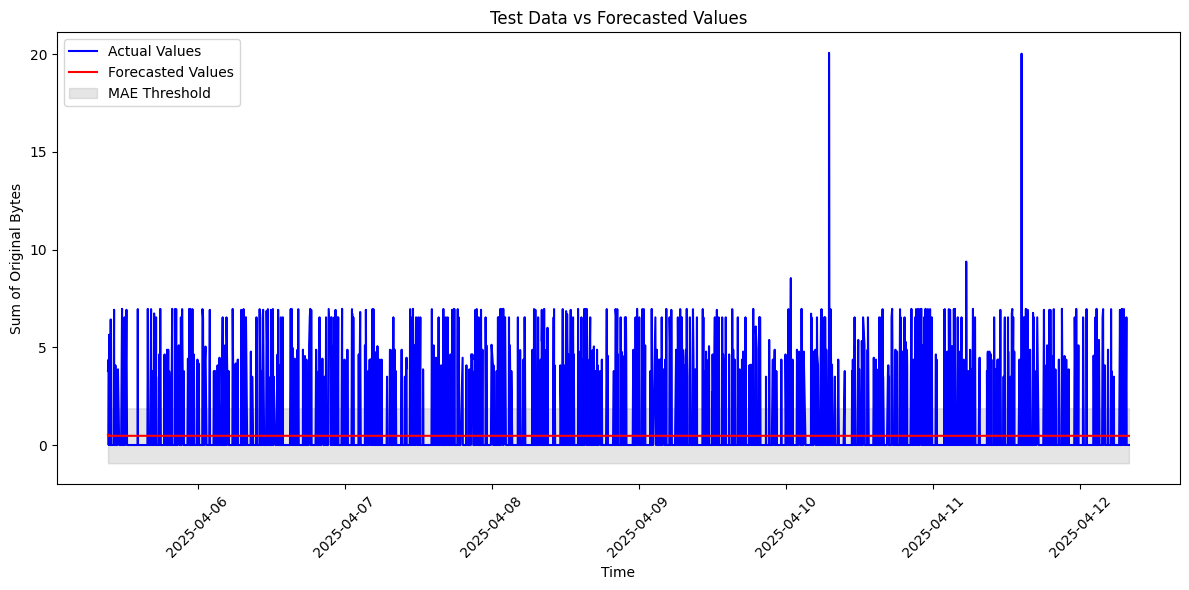

Calling Forecasted Data Processing Function
Columns in forecast_df:
Index(['Time', 'Actual', 'Forecast'], dtype='object')
Columns in df_test_original:
Index(['window_start', 'window_end', 'sum_duration', 'sum_orig_bytes',
       'sum_resp_bytes', 'sum_orig_ip_bytes', 'sum_resp_ip_bytes',
       'connection_count', 'label_tactic_binary_agg', 'label_tactic_split_agg',
       'label_tactic_binary_encoded_agg', 'sum_orig_bytes_log'],
      dtype='object')
7104   2025-04-05 09:22:26
7105   2025-04-05 09:26:26
7106   2025-04-05 09:28:26
7107   2025-04-05 09:29:26
7108   2025-04-05 09:33:26
Name: Time, dtype: datetime64[ns]

Type of decision_test_sample: <class 'pyspark.sql.dataframe.DataFrame'>
Type of filtered_result_df before conversion: <class 'pandas.core.frame.DataFrame'>

Type of filtered_result_df after conversion: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
# Import the functions from the Python script
from arima_functions import train_arima_model, process_forecast
# Import the functions from decision_tree_functions.py
from decision_tree_functions import (
    train_and_evaluate, 
    split_data, 
    train_test_2022_2022, 
    train_test_2024_2024, 
    train_2022_test_2024, 
    train_2024_test_2022, 
    train_test_2022_2022_oversampled, 
    train_test_2024_2024_oversampled, 
    train_2022_test_2024_oversampled, 
    train_2024_test_2022_oversampled
)

import pandas as pd

# Assuming df_train_sample and df_test_sample are already defined
# Call ARIMA Model Training Function
print("Calling ARIMA Model Training function")
forecast_df = train_arima_model(df_train_sample, df_test_sample)

# Call Forecasted Data Processing Function
print("Calling Forecasted Data Processing Function")
filtered_result_df = process_forecast(df_test_original, forecast_df)

# Print the datatypes of the inputs
print("\nType of decision_test_sample:", type(decision_test_sample))
print("Type of filtered_result_df before conversion:", type(filtered_result_df))

# Convert the DataFrames to Spark DataFrames
filtered_result_df = spark.createDataFrame(filtered_result_df)
print("\nType of filtered_result_df after conversion:", type(filtered_result_df))

Decision Tree Training and Testing

Columns and types in train_df:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


Entire test_df:


25/04/05 09:21:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:21:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:21:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0

+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|1.743863097E9|1.0991096496582031E-4|0         |0         |180          |0            |Reconnaissance   |
|1.743863337E9|2.3484230041503906E-4|0         |0         |176          |0            |Reconnaissance   |
|1.743863457E9|6.289482116699219E-4 |47        |47        |75           |75           |none             |
|1.743863517E9|2.2101402282714844E-4|0         |0         |132          |0            |Reconnaissance   |
|1.743863757E9|0.0011560916900634766|0         |0         |176          |160          |Reconnaissance   |
|1.743863817E9|5.090236663818359E-4 |0         |0         |176          |0            |Reconnaissance   |
|1.743863877E9|6.811618804931641E-4 |0        

25/04/05 09:22:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+
|        label_tactic|count|
+--------------------+-----+
|      Reconnaissance| 5658|
|                none|  835|
|   Credential Access|  590|
|      Initial Access|    7|
|         Persistence|    3|
|     Defense Evasion|    7|
|Privilege Escalation|    3|
|        Exfiltration|    1|
+--------------------+-----+

Distinct label counts in test_df:


25/04/05 09:22:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+-----------------+-----+
|     label_tactic|count|
+-----------------+-----+
|   Reconnaissance| 2383|
|             none|  305|
|   Initial Access|    1|
|Credential Access|  202|
|  Defense Evasion|    2|
|      Persistence|    2|
|        Discovery|    1|
+-----------------+-----+



25/04/05 09:23:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:23:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:23:02 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:23:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:23:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:23:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0


Model for label_tactic: Reconnaissance
Accuracy: 0.9906767955801105
Precision: 0.991696880633844
Recall: 0.9927486187845304
F1 Score: 0.9934228586965388

Predictions for each row in the test dataframe:


25/04/05 09:25:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:25:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0

+---------------------------------------------------+-----+----------+
|features                                           |label|prediction|
+---------------------------------------------------+-----+----------+
|[5.118846893310547E-4,0.0,0.0,176.0,160.0]         |1    |1.0       |
|[0.00414586067199707,118.0,118.0,202.0,202.0]      |0    |0.0       |
|[0.0044400691986083984,118.0,118.0,202.0,202.0]    |0    |0.0       |
|(5,[0,3],[2.2101402282714844E-4,132.0])            |1    |1.0       |
|(5,[0,3],[1.9693374633789062E-4,180.0])            |1    |1.0       |
|(5,[0,3],[5.14984130859375E-4,176.0])              |1    |1.0       |
|(5,[0,3],[2.391338348388672E-4,176.0])             |1    |1.0       |
|[0.029970884323120117,686.0,11329.0,5064.0,47844.0]|0    |0.0       |
|[0.003958940505981445,118.0,118.0,202.0,202.0]     |0    |0.0       |
|[4.4798851013183594E-4,0.0,0.0,240.0,160.0]        |1    |1.0       |
|[8.990764617919922E-4,0.0,0.0,240.0,160.0]         |1    |1.0       |
|(5,[0

25/04/05 09:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0

Length of y_true: 2896
Length of y_pred: 2896
Number of missing values in y_true: 0
Number of missing values in y_pred: 0


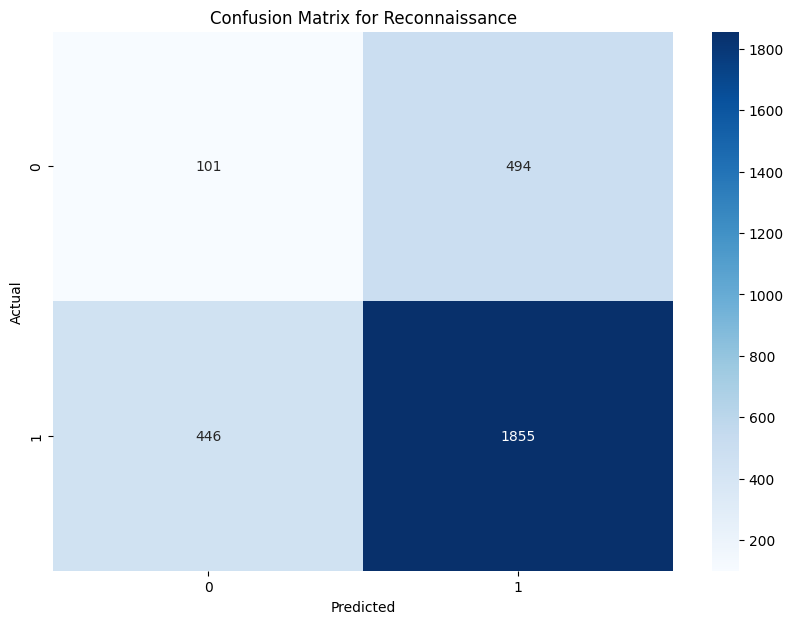

Confusion Matrix plotted.


In [4]:
#train_df, test_df, tactic, train_year, test_year, split_ratio

train_df = decision_train_sample
test_df = decision_test_sample

# Define the parameters
#tactic = "Credential Access"
tactic = "Reconnaissance"

train_year = "2024_2022"

test_year = "2024_2022"

split_ratio = "1"

# Print the columns and their types for train_df
print("Columns and types in train_df:")
train_df.printSchema()

# Print the test_df
print("\nEntire test_df:")
test_df.show(truncate=False)

#Show the distinct label counts
print("Distinct label counts in train_df:")
train_df.groupBy("label_tactic").count().show()
print("Distinct label counts in test_df:")
test_df.groupBy("label_tactic").count().show()

# Call the train_and_evaluate function
train_and_evaluate(train_df, test_df, tactic, train_year, test_year, split_ratio)

<span style = "color:blue; font-size:24px">Training with 2024 and 2022 Combined Data & Testing with ARIMA Result Dataframe</span>

Columns and types in train_df:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


Entire test_df:


25/04/05 09:26:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:26:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-------------------+---------------------+-------------------+------+----------+----------+-------------+-------------+--------------+
|window_start       |window_start       |duration             |Forecast           |Actual|orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic  |
+-------------------+-------------------+---------------------+-------------------+------+----------+----------+-------------+-------------+--------------+
|2025-04-05 09:29:26|2025-04-05 09:29:26|2.2101402282714844E-4|0.4983728702591781 |0.0   |0         |0         |132          |0            |Reconnaissance|
|2025-04-05 09:35:26|2025-04-05 09:35:26|0.0017240047454833984|0.4827052239986683 |0.0   |0         |0         |176          |160          |Reconnaissance|
|2025-04-05 09:39:26|2025-04-05 09:39:26|3.609657287597656E-4 |0.4797592128463129 |0.0   |0         |0         |132          |0            |Reconnaissance|
|2025-04-05 09:41:26|2025-04-05 09:41:26|1.1205673217773438E-5|0

25/04/05 09:27:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+--------------+-----+
|  label_tactic|count|
+--------------+-----+
|          none|  331|
|Reconnaissance| 2338|
+--------------+-----+

Distinct label counts in test_df:


25/04/05 09:27:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+-----+
|  label_tactic|count|
+--------------+-----+
|          none|   44|
|Reconnaissance| 2237|
+--------------+-----+



25/04/05 09:27:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 09:27:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/05 0


Model for label_tactic: Reconnaissance
Accuracy: 0.9938623410784744
Precision: 0.9937283490407056
Recall: 0.9938623410784744
F1 Score: 0.9933859981429568

Predictions for each row in the test dataframe:
+-------------------------------------------+-----+----------+
|features                                   |label|prediction|
+-------------------------------------------+-----+----------+
|(5,[0,3],[2.2101402282714844E-4,132.0])    |1    |1.0       |
|[0.0017240047454833984,0.0,0.0,176.0,160.0]|1    |1.0       |
|(5,[0,3],[3.609657287597656E-4,132.0])     |1    |1.0       |
|(5,[0,3],[1.1205673217773438E-5,240.0])    |1    |1.0       |
|(5,[0,3],[1.7881393432617188E-5,180.0])    |1    |1.0       |
|(5,[0,3],[3.829002380371094E-4,180.0])     |1    |1.0       |
|[2.3794174194335938E-4,0.0,78.0,0.0,134.0] |0    |1.0       |
|[9.100437164306641E-4,0.0,0.0,176.0,160.0] |1    |1.0       |
|(5,[0,3],[6.985664367675781E-5,180.0])     |1    |1.0       |
|(5,[0,3],[3.1185150146484375E-4,176.0])

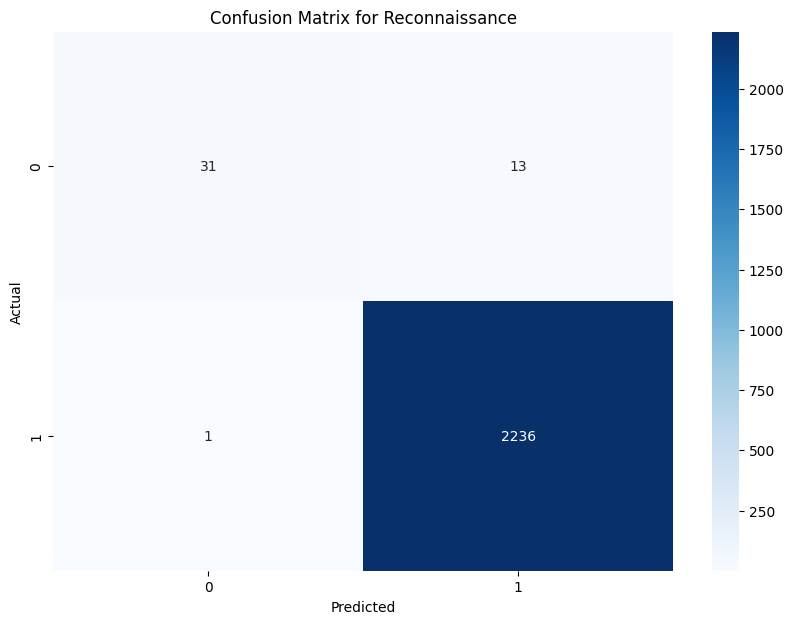

Confusion Matrix plotted.


In [5]:
#Define Test Variables for Decision Tree
#train_df, test_df, tactic, train_year, test_year, split_ratio

train_df = decision_test_sample

# Reduce train_df size to include only the first 70% of data
#train_df = train_df.limit(int(0.7 * train_df.count()))

test_df = filtered_result_df

#tactic = "Credential Access"
tactic = "Reconnaissance"

train_year = "2024"

test_year = "2022"

split_ratio = "1"

# Filter train_df to only include rows where label_tactic is either 'none' or the specified tactic
train_df = train_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Filter test_df to only include rows where label_tactic is either 'none' or the specified tactic
test_df = test_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Print the columns and their types for train_df
print("Columns and types in train_df:")
train_df.printSchema()

# Print the test_df
print("\nEntire test_df:")
test_df.show(truncate=False)

#Show the distinct label counts
print("Distinct label counts in train_df:")
train_df.groupBy("label_tactic").count().show()
print("Distinct label counts in test_df:")
test_df.groupBy("label_tactic").count().show()

# Call the train_and_evaluate function
train_and_evaluate(train_df, test_df, tactic, train_year, test_year, split_ratio)